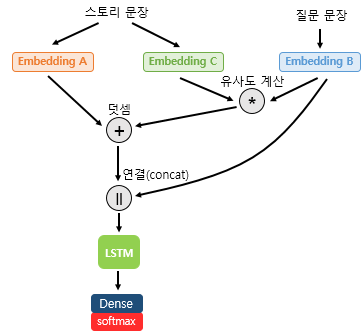

In [12]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [13]:
TRAIN_FILE = os.path.join("/content/drive/MyDrive/Colab Notebooks/qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("/content/drive/MyDrive/Colab Notebooks/qa1_single-supporting-fact_test_kor.txt")

In [14]:
i = 0
lines = open(TRAIN_FILE, "rb")
for l in lines: 
  l = l.decode('utf-8').strip()
  i += 1
  print(l)
  if i == 20:
    break
  

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [15]:
!pip install customized_konlpy

In [16]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.morphs('은경이는 복도로 이동했습니다.')

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '복도', '로', '이동', '했습니다', '.']

In [17]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [18]:
twitter.morphs('은경이는 복도로 이동했습니다.')

['은경이', '는', '복도', '로', '이동', '했습니다', '.']

In [19]:
def read_data(dir):
  stories, questions, answers = [], [], []

  story_tmp = []
  lines = open(dir, "rb")
  
  for l in lines:
    l = l.decode('utf-8')
    l = l.strip()
    idx, text = l.split(" ", 1)

    if int(idx) == 1:
      story_tmp = []

    if '\t' in text:
      question, answer, _ = text.split('\t')
      stories.append([x for x in story_tmp if x]) # 지금까지 누적 스토리로 스토리를 저장
      questions.append(question)
      answers.append(answer)

    else:
      story_tmp.append(text)

  lines.close()
  return stories, questions, answers

In [20]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [21]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [22]:
train_stories[0], train_questions[0], train_answers[0]

(['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.'], '필웅이는 어디야? ', '화장실')

In [23]:
train_stories[2], train_questions[2], train_answers[2]

(['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.'],
 '수종이는 어디야? ',
 '복도')

In [24]:
def tokenize(sent):
  return twitter.morphs(sent)

In [25]:
def preprocess_data(train_data, test_data):
  counter = FreqDist()

  # 하나의 문장으로 통합
  flatten = lambda data: reduce(lambda x,y : x + y, data)

  story_len = []
  question_len = []

  for stories, questions, answers in [train_data, test_data]:
    for story in stories:
      stories = tokenize(flatten(story))
      story_len.append(len(stories))

      for word in stories:
        counter[word] += 1

    for question in questions:
      question = tokenize(question)
      question_len.append(len(question))
      for word in question:
        counter[word] += 1
    
    for answer in answers:
      answer = tokenize(answer)
      for word in answer:
        counter[word] += 1

  # vocab
  word2idx = { word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
  idx2word = { idx : word for word, idx in word2idx.items() }

  return word2idx, idx2word, np.max(story_len), np.max(question_len)


In [26]:
word2idx, idx2word, story_max_len, question_max_len = \
preprocess_data(train_data, test_data)

In [27]:
word2idx

{'.': 2,
 '?': 23,
 '가버렸습니다': 11,
 '갔습니다': 17,
 '경임이': 6,
 '는': 1,
 '뛰어갔습니다': 12,
 '로': 3,
 '복귀': 13,
 '복도': 16,
 '부엌': 19,
 '사무실': 18,
 '수종이': 8,
 '야': 22,
 '어디': 21,
 '으로': 5,
 '은경이': 7,
 '이동': 10,
 '정원': 15,
 '침실': 20,
 '필웅이': 9,
 '했습니다': 4,
 '화장실': 14}

In [28]:
vocab_size = len(word2idx) + 1

In [29]:
def vectorize(data, word2_idx, story_max_len, question_max_len):
  Xs, Xq, Y = [], [], []

  flatten = lambda data: reduce(lambda x,y : x + y, data)

  stories, questions, answers = data
  for story, question, answer in zip(stories, questions, answers):
    xs = [word2idx[w] for w in tokenize(flatten(story))]
    xq = [word2idx[w] for w in tokenize(question)]
    Xs.append(xs)
    Xq.append(xq)
    Y.append(word2idx[answer])

  return pad_sequences(Xs, maxlen=story_max_len), \
         pad_sequences(Xq, maxlen=question_max_len), \
         to_categorical(Y, num_classes=len(word2idx) + 1)



In [30]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx,
                                     story_max_len, question_max_len)

In [31]:
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx,
                                  story_max_len, question_max_len)

In [32]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


In [33]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [34]:
train_epochs = 120
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.3

In [35]:
input_sequence = Input((story_max_len, ))
question = Input((question_max_len, ))

In [36]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))

In [37]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))

In [38]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))

In [39]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [40]:
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
match

<tf.Tensor 'activation/truediv:0' shape=(None, 70, 5) dtype=float32>

In [41]:
resp = add([match, input_encoded_c])
resp = Permute((2, 1))(resp)
resp

<tf.Tensor 'permute/transpose:0' shape=(None, 5, 70) dtype=float32>

In [42]:
answer = concatenate([resp, question_encoded])
answer

<tf.Tensor 'concatenate/concat:0' shape=(None, 5, 120) dtype=float32>

In [43]:
answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)

answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

In [44]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [45]:
history = model.fit(x=[Xstrain, Xqtrain], y=Ytrain,
                    batch_size= batch_size, epochs=train_epochs,
                    validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120
313/313 [==============================] - 4s 12ms/step - loss: 1.8902 - acc: 0.1782 - val_loss: 1.7637 - val_acc: 0.2860
Epoch 2/120
313/313 [==============================] - 3s 9ms/step - loss: 1.6917 - acc: 0.2750 - val_loss: 1.6253 - val_acc: 0.3350
Epoch 3/120
313/313 [==============================] - 3s 9ms/step - loss: 1.6101 - acc: 0.3380 - val_loss: 1.4922 - val_acc: 0.4560
Epoch 4/120
313/313 [==============================] - 3s 9ms/step - loss: 1.4908 - acc: 0.4287 - val_loss: 1.4172 - val_acc: 0.4780
Epoch 5/120
313/313 [==============================] - 3s 9ms/step - loss: 1.4469 - acc: 0.4466 - val_loss: 1.4080 - val_acc: 0.4790
Epoch 6/120
313/313 [==============================] - 3s 9ms/step - loss: 1.4145 - acc: 0.4601 - val_loss: 1.3737 - val_acc: 0.4910
Epoch 7/120
313/313 [==============================] - 3s 9ms/step - loss: 1.3674 - acc: 0.4851 - val_loss: 1.3135 - val_acc: 0.5090
Epoch 8/120
313/313 [==============================] - 3s 9ms/step -

In [46]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.2625 - acc: 0.9590

 테스트 정확도: 0.9590


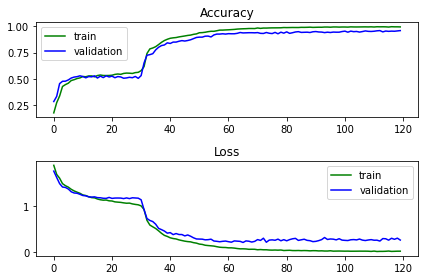

In [47]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)